### **Predicting House Prices with Regression using TensorFlow**

The model is trying to predict the price of the houses given a set of variables.

# Overview

---

We are going to evaluate the price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude


## 1.1: Import Libraries & Functions

In [ ]:
pip install --upgrade tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.9.1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print('Libraries imported.')

Libraries imported.


Import functions.

In [ ]:
import matplotlib.pyplot as plt

column_names = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']

def plot_loss(history):
    h = history.history
    x_lim = len(h['loss'])
    plt.figure(figsize=(8, 8))
    plt.plot(range(x_lim), h['val_loss'], label = 'Validation Loss')
    plt.plot(range(x_lim), h['loss'], label = 'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

def plot_predictions(preds, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds, y_test, 'ro')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.plot([-0.5, 0.5], [-0.5, 0.5], 'b--')
    plt.show()
    return

def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds1, y_test, 'ro', label='Untrained Model')
    plt.plot(preds2, y_test, 'go', label='Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

# Import the Data & check overview

## 2.1: Importing the Data

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict House Prices using TensorFlow/data.csv', names=column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

Check if there are missing values

In [ ]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [ ]:
#Ignore the  first column as its an index.
df=df.iloc[:,1:]
df.head()

,date,age,distance,stores,latitude,longitude,price
0,2009,21,9,6,84,121,14264
1,2007,4,2,3,86,121,12032
2,2016,18,3,7,90,120,13560
3,2002,13,2,2,80,128,12029
4,2014,25,5,8,81,122,14157


In [ ]:
df_norm=(df-df.mean())/df.std()

In [ ]:
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

In [ ]:
#Create a function to revert normalised values back to their original form
y_mean=df['price'].mean()
y_std=df['price'].std()

def convert_label_value(pred):
    return int(pred* y_std + y_mean)

# 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [ ]:
#T Assign the first 6 columns to X,since the last column is the target column.
X= df_norm.iloc[:,:6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [ ]:
y=df_norm.iloc[:, -1]
y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We can access the values as arrays by using the .values function.

In [ ]:
X_arr=X.values
y_arr=y.values

print('features array shape:', X_arr.shape)
print('features array shape:', y_arr.shape)

features array shape: (5000, 6)
features array shape: (5000,)


## 4.4: Train and Test Split


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_arr, y_arr, test_size=0.05, random_state=0)

X_train.shape
y_test.shape

(250,)

#  5: Create the Model

## 5.1: Create the Model

Define a function that returns an untrained model with 3 hidden fully connected layers. The number of parameters correspond to the number of nodes.

In [ ]:
def get_model():
  model=Sequential([
      Dense(10, input_shape=(6,), activation='relu'), 
      Dense(20, activation='relu'),
      Dense(5, activation='relu'),
      #Output layer
      Dense(1)
  ])
    #We need to compile the function
  model.compile(
        #The algorithm will try to minimise this loss function.
        loss='mse',
        # Stochastic gradient descent called adam.
        optimizer='adam'
    )
  return model
  # Use the summary function from Keras to see the model architecture.
get_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

The validation  loss is calculated on the test set and not on the training set.

In [ ]:
#The early stoploss callback function will monitor the validation loss and will wait for 5 epochs before it will decide to stop the training.
#If the validation loss does not decrease for 5 epochs, it till stop the training.

es_cb=EarlyStopping(monitor='val_loss', patience=5)

model=get_model()
preds_on_untrained=model.predict(X_test)

history=model.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      epochs=100,
      callbacks=[es_cb]
)


8/8 [==============================] - 0s 2ms/step
Epoch 1/100
149/149 [==============================] - 1s 3ms/step - loss: 0.6119 - val_loss: 0.2742
Epoch 2/100
149/149 [==============================] - 0s 2ms/step - loss: 0.2513 - val_loss: 0.1846
Epoch 3/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1944 - val_loss: 0.1687
Epoch 4/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1785 - val_loss: 0.1613
Epoch 5/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1703 - val_loss: 0.1591
Epoch 6/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1663 - val_loss: 0.1524
Epoch 7/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1634 - val_loss: 0.1541
Epoch 8/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1603 - val_loss: 0.1504
Epoch 9/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1601 - val_loss: 0.1496
Epoch 10/100
149/149 [==================

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

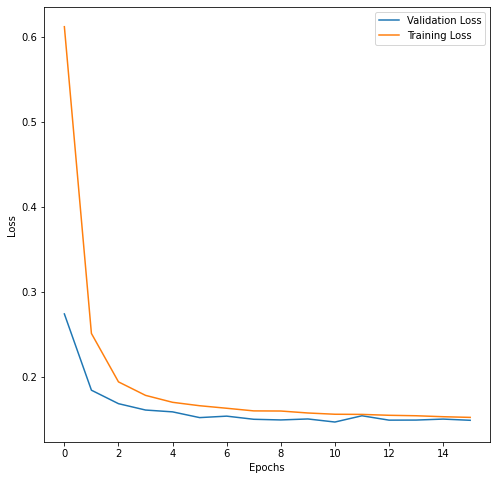

In [ ]:
plot_loss(history)

# 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

8/8 [==============================] - 0s 3ms/step


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


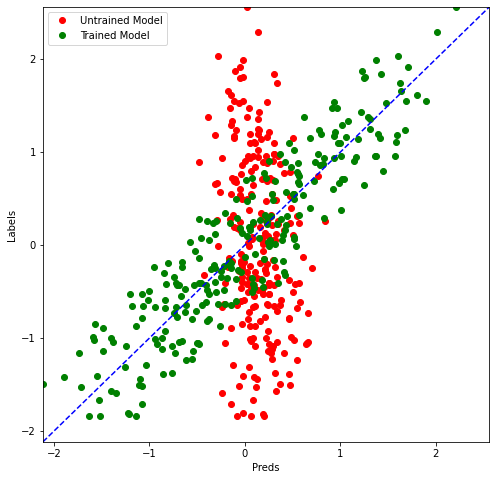

In [ ]:
preds_on_trained=model.predict(X_test)
compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for normalised vs real-range price predictions will look the same with just one difference: The x and y axis scale is changed.

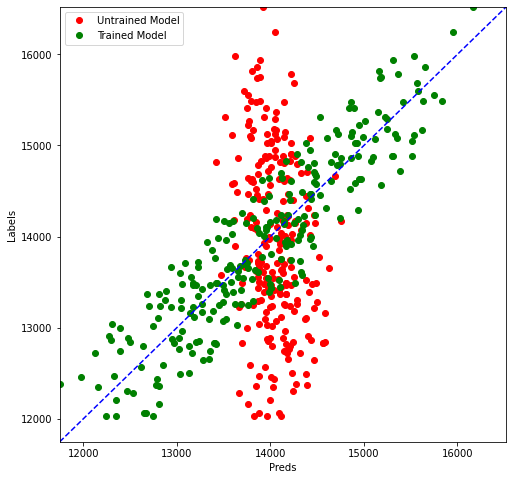

In [ ]:
price_untrained=[convert_label_value(y) for y in preds_on_untrained]
price_trained=[convert_label_value(y) for y in preds_on_trained]
price_test=[convert_label_value(y) for y in y_test]

compare_predictions(price_untrained, price_trained, price_test)